In [38]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from src.training_controller import Trainer
from src.helper_funcs import conv_block, ResidualBlock, calculate_accuracy
from datetime import datetime

print(torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.device_count(), torch.cuda.get_device_name(0))

True 0 1 NVIDIA GeForce GTX 1060 6GB


## Model 

The model below adapts a ResNet architecture with 4 blocks. Each residual block was implemented with the custom ResidualBlock class and each block resizes the input two times. The individual sizes can be set in an array whoch will be given as an initial input to the class. Among other functionalities, the addition of the input will be handled in the ResidualBlock class as well. <br>

The boolean denotes whether the input should be resized to a different output or whether the input should be scaled to an intermediate size and then back to it's original size. <br>
Eventually the classifier is reached which takes the output of the final residual block, processes it through a few additional layers and delivers a classification.

In [39]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.res1 = ResidualBlock([3,8,16], True)
        self.res2 = ResidualBlock([16, 32, 64], True)
        self.res3 = ResidualBlock([64,128, 256], True)     
        self.res4 = ResidualBlock([256,512, 1024], True)

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(1024, 256),
                                        nn.ReLU(),
                                        nn.Linear(256, 6)
                                       )

    def forward(self, x):

        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
 
        x = self.classifier(x)

        return x
model = ResNet()

## Defining transforms and training parameters

Here the training parameters and methods of data augmentation are defined to help the model generalize. <br>

During training I also chose to use a scheduler and momentum to help the algortihm converge.

In [40]:
my_transforms = transforms.Compose(
    [
        transforms.CenterCrop(size=(100, 100)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        # transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(1), saturation=(0.5, 1.5), hue=(-0.1, 0.1)),
        transforms.ToTensor()
    ])

my_eval_transforms = transforms.Compose(
    [
        transforms.CenterCrop(size=(100, 100)),
        transforms.ToTensor(),
    ])

batch_size = 32
max_lr = 0.0006

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=max_lr,
                      weight_decay=1e-4,
                      momentum=0.9
                     )

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, step_size_up = 20, base_lr=0.0001, max_lr=max_lr)


## Training

Trainer class which offers a training method and validation methods. Currently, the class expects the data to be in an [imagefolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html) type fashion.

In [41]:
model = torch.jit.load("Models/script.pt")

my_trainer = Trainer(model, 'Data/seg_train/', 'Data/seg_test',
                  transform=my_transforms, eval_transform=my_eval_transforms,
                  gradient_clipping=True, batch_size=32, loss_function=criterion,
                  optimizer=optimizer, scheduler=scheduler, epochs=30)

In [ ]:
my_trainer.train()

## Evaluate the model

A function which takes a dataloader and a model as an input an returns the accuracy

In [19]:
acc = calculate_accuracy(my_trainer._testloader, my_trainer.getModel())
acc

75

visualize_results() gives a quick overview of how the loss and accuracy behaved during training in a simple line plot

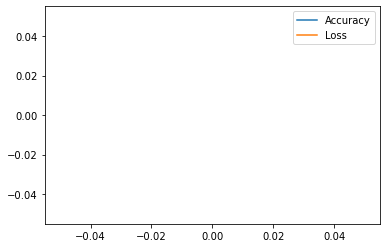

In [6]:
my_trainer.visualize_results()

visualize_incorrectly_classified_images() takes an integer n as an input and displays an array of n random images that have been incorrectly classified by the model. This might help identifying what classes the model fails to identify properly and may guide one to different augmentation techniques.

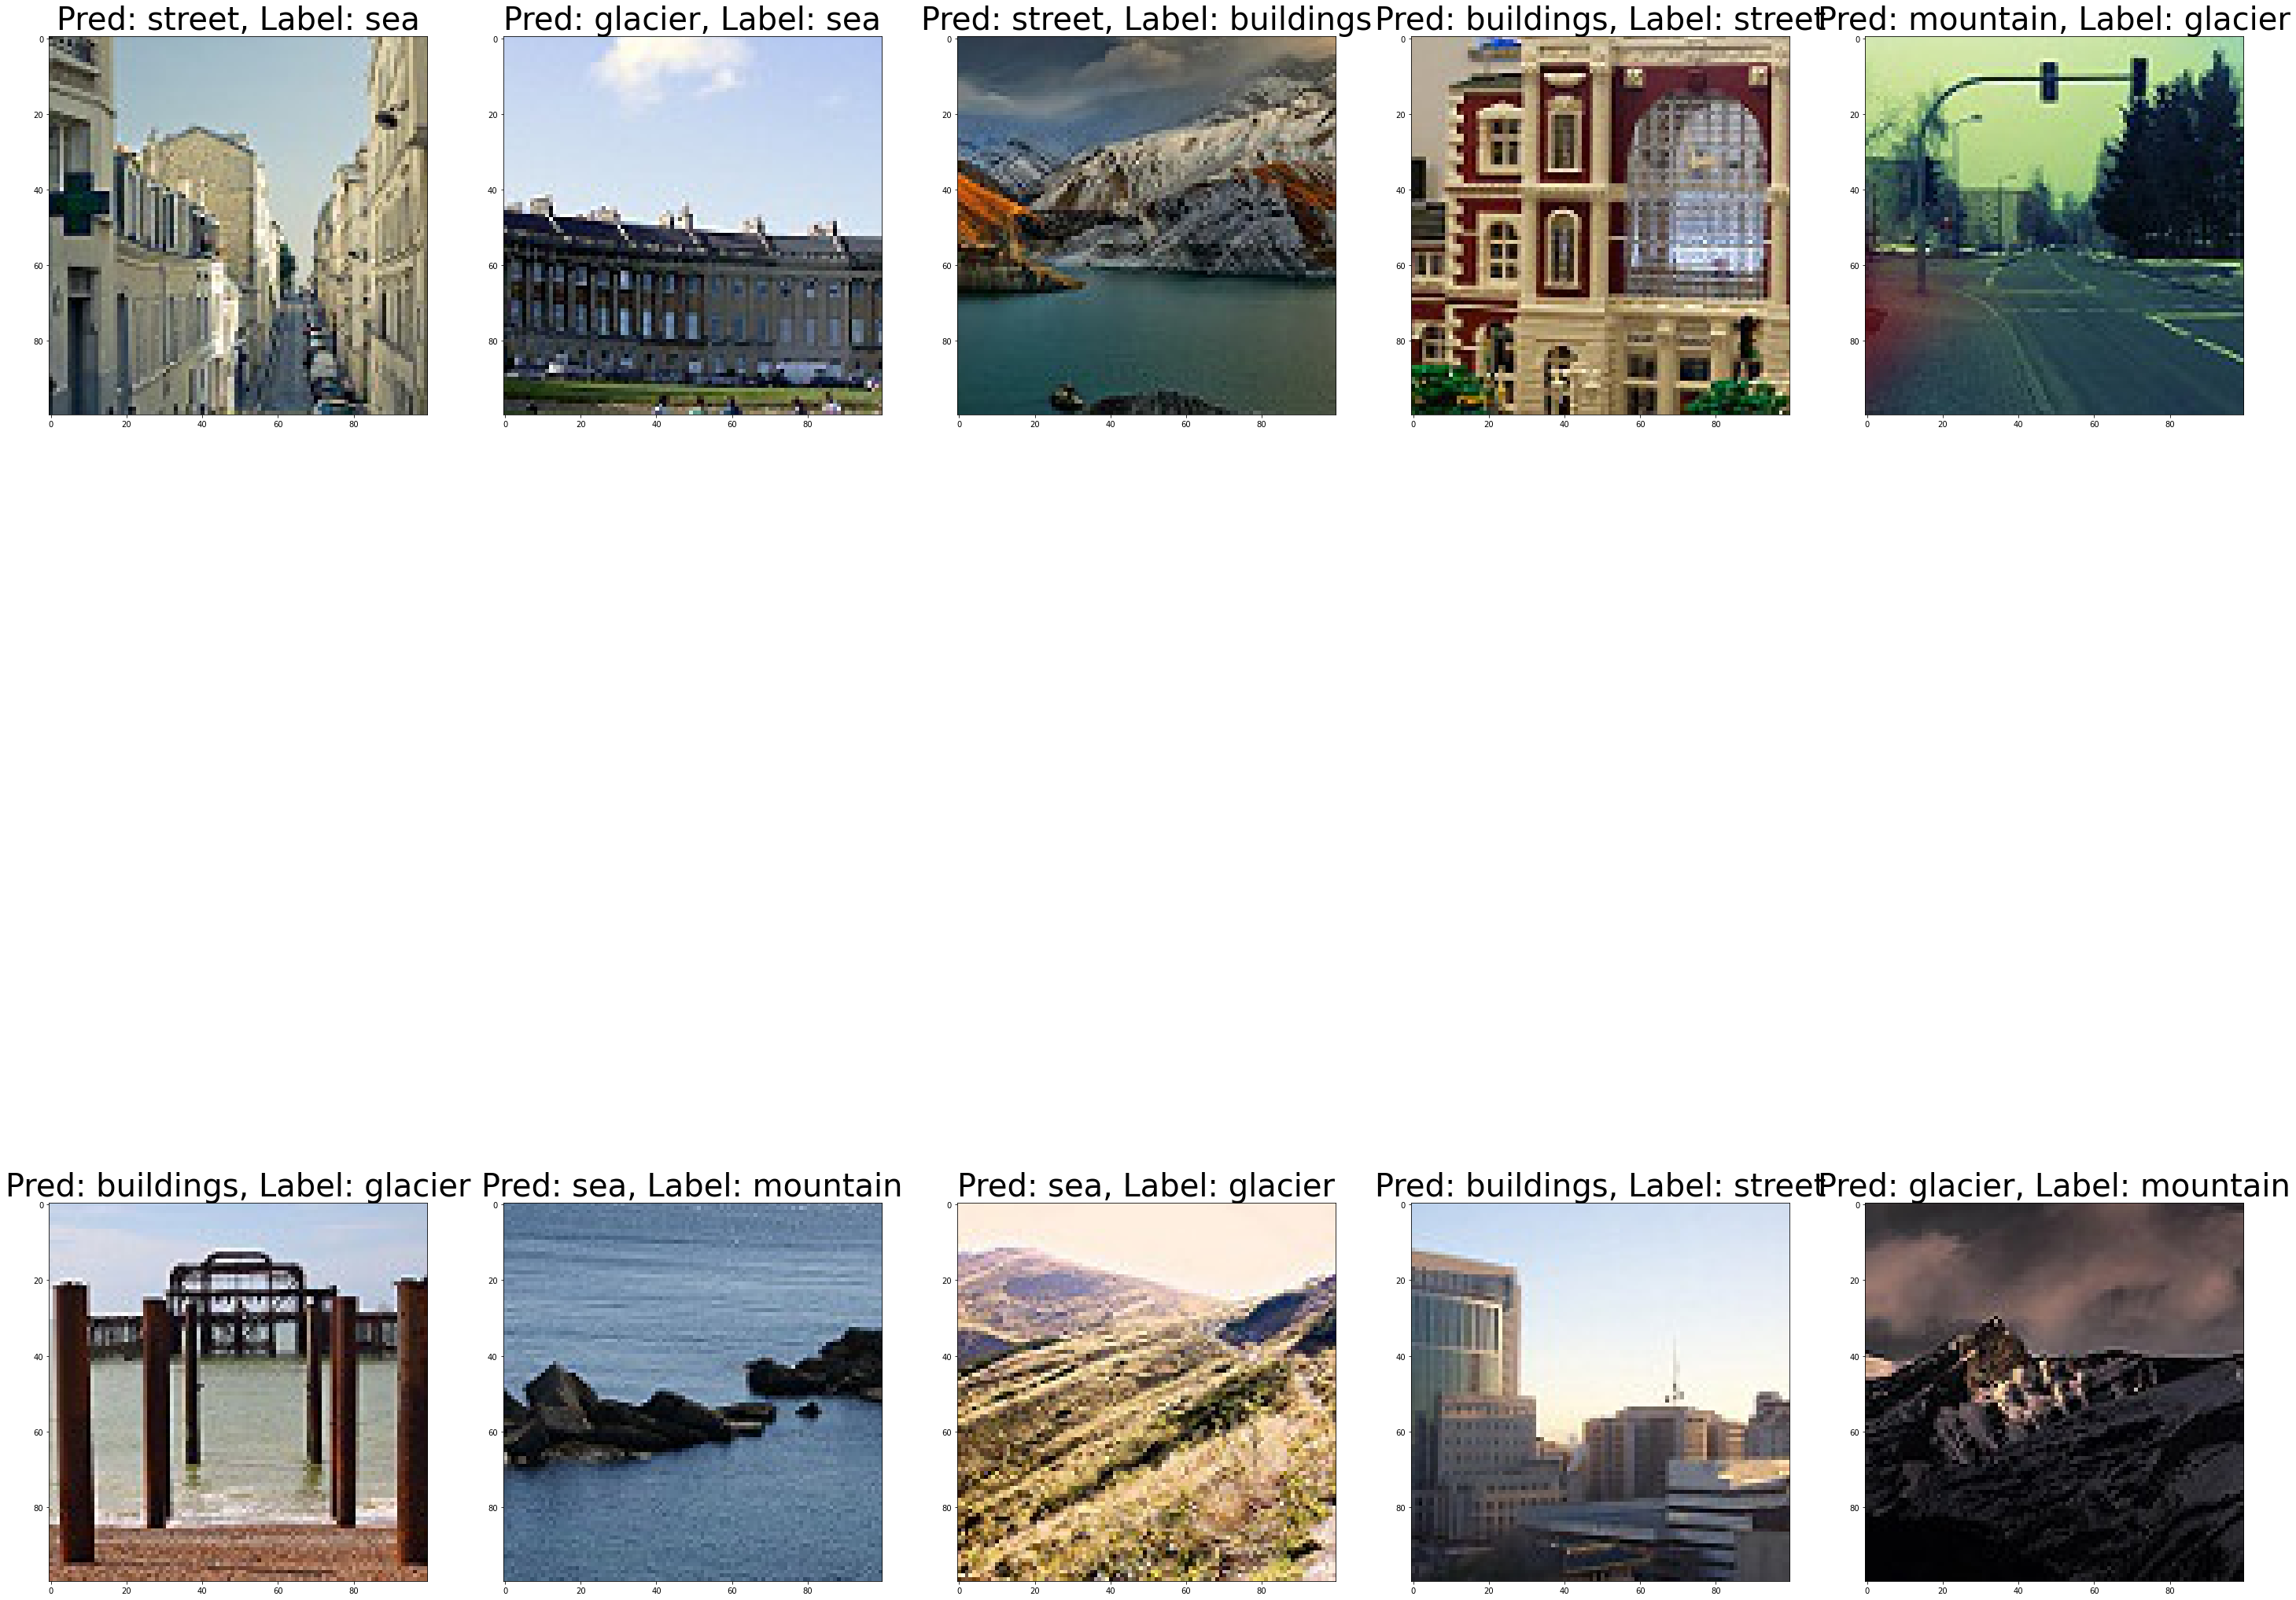

In [42]:
my_trainer.visualize_incorrectly_classified_images(10)

## Save the model

Save the model as a script such that the python class doesn't need to be defined anymore when loading the model back in.

In [43]:
m = torch.jit.script(my_trainer.getModel())
torch.jit.save(m, "Models/script.pt")

## Demonstration on a single image

In [44]:
model = torch.jit.load("Models/script.pt")

In [45]:
from PIL import Image

In [48]:
img = Image.open("image.JPG")
transform = transforms.Compose(
    [
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
    ])

img = transform(img)

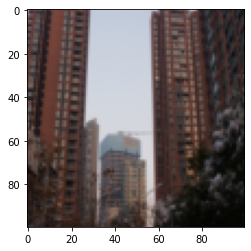

In [49]:

import matplotlib.pyplot as plt
plt.imshow( img.permute(1, 2, 0) )


In [50]:
pred_translator = {
    0: "buildings",
    1: "forest",
    2: "glacier",
    3: "mountain",
    4: "sea",
    5: "street",
}

img = torch.unsqueeze(img, 0)
img = img.to('cuda')

outputs = my_trainer.getModel()(img)
_, preds = torch.max(outputs, dim=1)
print(outputs, pred_translator[preds.item()])

tensor([[ 17.3453,  -3.6417,  -3.0044, -16.7006,   0.5450,   2.9872]],
       device='cuda:0', grad_fn=<AddmmBackward0>) buildings
